In [156]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

def household_guess(a_grid,r,z_grid,gamma,T):
    new_z = np.ones((z_grid.shape[0],1))
    wel = (1 + r) * a_grid[np.newaxis,:] + new_z + T[:,np.newaxis]
    V_prime = (1 + r) * (wel * 0.1) ** (-gamma)
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc):

    c_prime = (beta * V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t

    new_grid = (1 + tauc) * c_prime + a_grid[np.newaxis,:] - z_grid[:,np.newaxis] - T[:,np.newaxis]
    wel = (1 + r) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)

    a = wel + z_grid[:,np.newaxis] + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r) * c ** (-gamma)

    # checks for violations of the condition of minimal assets required and fixes it
    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:
        
        a[indexes_asset] = a_grid[0]
        c[indexes_asset] = (wel[indexes_asset[1]] + z_grid[indexes_asset[0]] 
                            + T[indexes_asset[0]] - a[indexes_asset]) / (1 + tauc)
        V_prime[indexes_asset] = (1 + r) * (c[indexes_asset]) ** (-gamma)
        
    uce = e_grid[:,np.newaxis] * c ** (-gamma)

    return V_prime,a,c,uce

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<HetBlock 'household'>
Inputs: ['a_grid', 'z_grid', 'e_grid', 'r', 'T', 'beta', 'gamma', 'v', 'tauc', 'Pi']
Macro outputs: ['A', 'C', 'UCE']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c', 'uce']


In [157]:
def income(e_grid, w, N, taun):
    z_grid = (1 - taun) * w * N * e_grid
    return z_grid

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  (Transfer) / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

hh_inp = household.add_hetinputs([make_grid,transfers,income])

print(hh_inp)
print(f'Inputs: {hh_inp.inputs}')
print(f'Outputs: {hh_inp.outputs}')

<HetBlock 'household' with hetinput 'make_grid_transfers'>
Inputs: ['r', 'beta', 'gamma', 'v', 'tauc', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer', 'w', 'N', 'taun']
Outputs: ['A', 'C', 'UCE']


In [191]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    N = Y / Z
    Div = Y - w * N - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return Div, N

@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    return r

@simple
def fiscal(r, Transfer, B, C, N, tauc, taun, w):
    govt_res = Transfer + (1 + r) * B(-1) - tauc * C - taun * w * N - B
    deficit = Transfer - tauc * C - taun * w * N # primary deficit
    return govt_res, deficit

@simple
def mkt_clearing(A, C, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple 
def union_ss(w, N, UCE, kw, v, muw, tauc, taun):
    phi = ((1 - taun) * w * N ** (-v) * UCE) / ((1 + tauc) * muw) # our formula
    wnkpc = kw * (phi * N ** (1 + v) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw))
    return wnkpc, phi

@simple 
def auclert_union_ss(w, N, UCE, kw, v, muw, tauc, taun):
    phi = (w * UCE) / (muw * N ** (1 + v)) # our formula
    wnkpc = kw * (phi * N ** (1 + v) - w / muw * UCE)
    
    #vphi = w * UCE / muw / N ** (1 + 1 / v) # their formula
    #wnkpc = vphi * N ** (1 + 1 / frisch) - (1 - tax) * w * UCE / muw
    return wnkpc, phi

In [192]:
blocks_ss = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc_ss, union_ss]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'v', 'tauc', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Transfer', 'taun', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B', 'kw', 'muw']


In [199]:
calibration = {'gamma': 1.0, 'v': 2.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 0.0, 'B': 6.0,
               'kw': 100.0, 'muw': 1.2, 'N': 1.0, 'tauc': 0.2, 'taun': 0.0}

unknowns_ss = {'beta': 0.986, 'Transfer': -0.03}
targets_ss = {'asset_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

In [200]:
# Show steady state
eps = ss0['mu'] / (ss0['mu'] - 1)
epsw = ss0['muw'] / (ss0['muw'] - 1)
print("PARAMETERS")
print(f"Discount factor:         {ss0['beta']: .3}", f"      Intertemporal elasticity: {ss0['gamma']}")
print(f"Labor supply elasticity:  {1 / ss0['v']}", f"       Labor disutility:        {ss0['phi']: .3}")
print(f"Goods substitutability:  {eps : .3}", f"       Price markup:            {ss0['mu']: .3}")
print(f"Labor substitutability:  {epsw : .3}", f"       Wage markup:             {ss0['muw']: .3}")
print(f"Price Phillips slope:    {ss0['kappa']: .3}", f"      Wage Phillips slope:     {ss0['kw']: .3}")
print(f"Taylor inflation:        {ss0['phi_pi']: .3}")
print(f"Consumption tax rate:    {ss0['tauc']: .3}", f"       Labor tax rate:          {ss0['taun']: .3}")

print()
print("STEADY STATE")
print(f"Output:                  {ss0['N'] * ss0['Z']: .3}", f"       Government debt:         {ss0['A']: .3}")
print(f"Hours:                   {ss0['N']: .3}", f"       Transfers:               {ss0['Transfer']: .3}")
print(f"Consumption:             {ss0['C']: .3}", f"       Dividends:               {ss0['Div']: .3}")
print(f"Wage:                    {ss0['w']: .3}", f"     Deficit:                 {ss0['deficit']: .3}")
print(f"Inflation:               {ss0['pi']: .3}", f"       Consumption tax revenue: {ss0['tauc']*ss0['C']: .3}")
print(f"Nominal interest rate:   {ss0['r']: .3}", f"     Labor tax revenue:       {ss0['taun']*ss0['N']*ss0['w']: .3}")
print(f"Real interest rate:      {ss0['r']: .3}" , f"     Debt servicing cost:     {ss0['r'] * ss0['A']: .3}") 

print()
print("MARKET CLEARING")
print(f"Bond market:             {ss0['asset_mkt']: 0.1e}", f"   Goods market (resid):    {ss0['goods_mkt']: 0.1e}")
print(f"Government budget:       {ss0['govt_res']: 0.1e}",)


PARAMETERS
Discount factor:          0.99       Intertemporal elasticity: 1.0
Labor supply elasticity:  0.5        Labor disutility:         0.557
Goods substitutability:   6.0        Price markup:             1.2
Labor substitutability:   6.0        Wage markup:              1.2
Price Phillips slope:     0.1       Wage Phillips slope:      1e+02
Taylor inflation:         0.0
Consumption tax rate:     0.2        Labor tax rate:           0.0

STEADY STATE
Output:                   1.0        Government debt:          6.0
Hours:                    1.0        Transfers:                0.17
Consumption:              1.0        Dividends:                0.167
Wage:                     0.833      Deficit:                 -0.03
Inflation:                0.0        Consumption tax revenue:  0.2
Nominal interest rate:    0.005      Labor tax revenue:        0.0
Real interest rate:       0.005      Debt servicing cost:      0.03

MARKET CLEARING
Bond market:              1.1e-09    Goods market

In [201]:
@simple
def wage(pi, w):
    piw = (1 + pi) * w / w(-1) - 1
    return piw

@simple
def union(piw,w,N,UCE,kw,phi,v,muw,beta,tauc,taun):
    wnkpc = (kw * (phi * N ** (1+v) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw)) 
             + beta * (1 + piw(+1)).apply(np.log) - (1 + piw).apply(np.log))
    return wnkpc

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc,wage,union]
hank = create_model(blocks, name = "One-Asset HANK")

In [202]:
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

In [203]:
T = 300
exogenous = ['rstar','Transfer', 'Z', 'tauc']
unknowns = ['pi', 'w', 'Y', 'B']
targets = ['nkpc_res', 'asset_mkt', 'wnkpc', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'Y', 'B', 'A', 'C', 'UCE', 'Div', 'N', 'r', 'govt_res', 'deficit', 'asset_mkt', 'goods_mkt', 'nkpc_res', 'piw', 'wnkpc'], inputs=['rstar', 'Transfer', 'Z', 'tauc']>


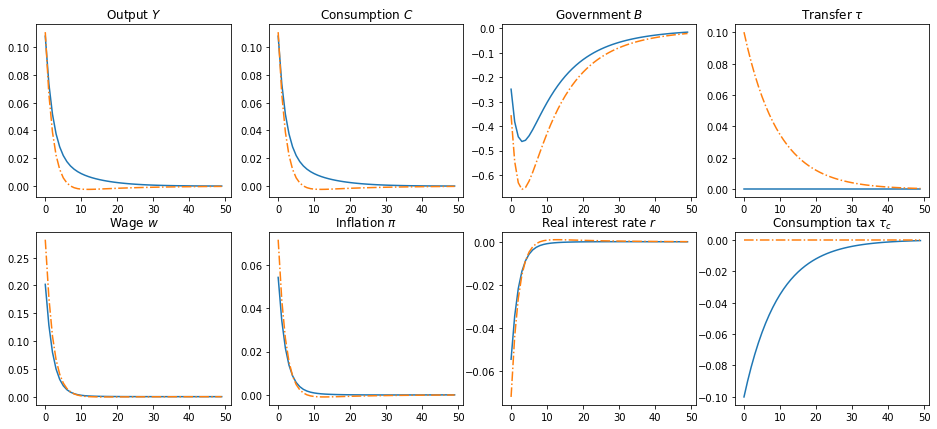

In [217]:
rhos = 0.9
drstar = -0.25 * 0 * rhos ** (np.arange(T)[:, np.newaxis])
dtstar = 0.1 * rhos ** (np.arange(T)[:, np.newaxis])
dtauc = - 0.1 * rhos ** (np.arange(T)[:, np.newaxis])

dY_r = G['Y']['rstar'] @ drstar
dC_r = G['C']['rstar'] @ drstar
dN_r = G['N']['rstar'] @ drstar
dB_r = G['A']['rstar'] @ drstar
dw_r = G['w']['rstar'] @ drstar
dpi_r = G['pi']['rstar'] @ drstar
dr_r = G['r']['rstar'] @ drstar
#di = G['i']['rstar'] @ drstar

dY_t = G['Y']['Transfer'] @ dtstar
dC_t = G['C']['Transfer'] @ dtstar
dN_t = G['N']['Transfer'] @ dtstar
dB_t = G['A']['Transfer'] @ dtstar
dD_t = G['deficit']['Transfer'] @ dtstar
dw_t = G['w']['Transfer'] @ dtstar
dpi_t = G['pi']['Transfer'] @ dtstar
dr_t = G['r']['Transfer'] @ dtstar
#dit = G['i']['Transfer'] @ dtstar

dY_c = G['Y']['tauc'] @ dtauc
dC_c = G['C']['tauc'] @ dtauc
dN_c = G['N']['tauc'] @ dtauc
dB_c = G['A']['tauc'] @ dtauc
dD_c = G['deficit']['tauc'] @ dtauc
dw_c = G['w']['tauc'] @ dtauc
dpi_c = G['pi']['tauc'] @ dtauc
dr_c = G['r']['tauc'] @ dtauc
#dic = G['i']['tauc'] @ dtauc

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 4)
l1, = ax[0, 0].plot(dY_c[:50, :])
l2, = ax[0, 0].plot(dY_t[:50, :],'-.')
ax[0, 0].set_title(r'Output $Y$')

ax[0, 1].plot(dC_c[:50, :])
ax[0, 1].plot(dC_t[:50, :],'-.')
ax[0, 1].set_title(r'Consumption $C$')

ax[0, 2].plot(dB_c[:50, :])
ax[0, 2].plot(dB_t[:50, :],'-.')
ax[0, 2].set_title(r'Government $B$')

ax[0, 3].plot(np.zeros(50))
ax[0, 3].plot(dtstar[:50],'-.')
ax[0, 3].set_title(r'Transfer $\tau$')

ax[1, 0].plot(dw_c[:50, :])
ax[1, 0].plot(dw_t[:50, :],'-.')
ax[1, 0].set_title(r'Wage $w$')

ax[1, 1].plot(dpi_c[:50, :])
ax[1, 1].plot(dpi_t[:50, :],'-.')
ax[1, 1].set_title(r'Inflation $\pi$')

ax[1, 2].plot(dr_c[:50, :])
ax[1, 2].plot(dr_t[:50, :],'-.')
ax[1, 2].set_title(r'Real interest rate $r$')

#ax[1, 3].plot(10000 * drstar[:50])
#ax[1, 3].plot(10000 * np.zeros(50),'-.')
#ax[1, 3].set_title(r'Nominal interest rate $i$')

ax[1, 3].plot(dtauc[:50])
ax[1, 3].plot(np.zeros(50),'-.')
ax[1, 3].set_title(r'Consumption tax $\tau_c$')

#ax.legend((l1, l2), ('MonPol', 'Check'), loc='upper right', shadow=True)
plt.show()

In [213]:
100 * dY_c[0] - 100 * dY_t[0]

array([-0.00288929])

In [227]:
dtstar[0:10,:] + dtauc[0:10,:]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])